# Hand digit classifier baseline
---
## Floating point precision weights

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from skimage import io

### Importing MNIST dataset

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='../', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../", train=False, download=True, transform=transform)

train_set = [train_data[i] for i in range(50000)]
validation_set = [train_data[i] for i in range(50000, 60000)]

### Setting up data loaders

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Definig a VGG-7 inspired architecture model
---
Featuring 4 convolutional and 3 fully connected layers

In [4]:
class VGG7(nn.Module):
    def __init__(self):
        super(VGG7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding="same", stride=1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 3, padding="same", stride=1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding="same", stride=1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, padding="same", stride=1, bias=False)
        
        self.fc1 = nn.Linear(7*7*128, 512, bias=False)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.fc3 = nn.Linear(256, 10, bias=False)

    def forward(self, x): 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)  

        x = x.view(-1, 7*7*128)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  

        x = F.log_softmax(x, dim=1)  

        return x

### Device initialization for training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training

In [6]:
net = VGG7()
net.to(device)

optimizer = optim.SGD(net.parameters(), lr = 1e-2, weight_decay=0)

logs_interval = 100
epochs = 10

train_losses = []
iteration = 0

net.train()

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        iteration = iteration + 1
        if iteration % logs_interval == 0:
            print('Train epoch:{}, batch index:{}, loss:{}'.format(epoch, batch_idx, loss.item()/logs_interval))
            train_losses.append(loss.item())

torch.save(net, "baseline.pth")

Train epoch:0, batch index:99, loss:0.023016703128814698
Train epoch:0, batch index:199, loss:0.02301396369934082
Train epoch:0, batch index:299, loss:0.02300480127334595
Train epoch:0, batch index:399, loss:0.02299464702606201
Train epoch:0, batch index:499, loss:0.02297706365585327
Train epoch:0, batch index:599, loss:0.02291097640991211
Train epoch:0, batch index:699, loss:0.022857799530029296
Train epoch:1, batch index:17, loss:0.02244194984436035
Train epoch:1, batch index:117, loss:0.014411649703979491
Train epoch:1, batch index:217, loss:0.00801357090473175
Train epoch:1, batch index:317, loss:0.005665767192840576
Train epoch:1, batch index:417, loss:0.003815625309944153
Train epoch:1, batch index:517, loss:0.003314356803894043
Train epoch:1, batch index:617, loss:0.003037271499633789
Train epoch:1, batch index:717, loss:0.0025445002317428587
Train epoch:2, batch index:35, loss:0.002961798906326294
Train epoch:2, batch index:135, loss:0.0045969834923744205
Train epoch:2, batch i

### Evaluate model performance on test data

Test set average loss: 0.04936047224765643, accuracy: 98.45%


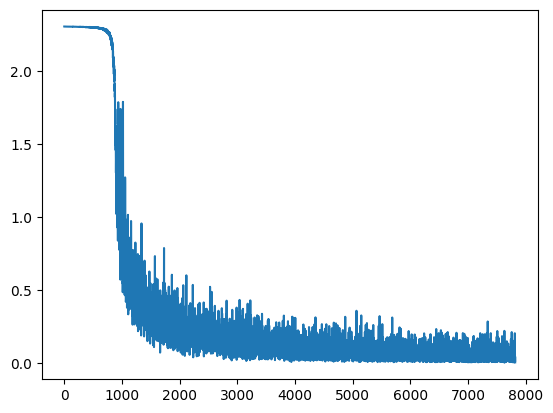

In [10]:
net.eval()
loss = 0
correct = 0

confusion_matrix = np.zeros((10, 10))

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss += F.nll_loss(output, target, reduction="sum").item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        confusion_matrix[pred.cpu()[:, 0], target.cpu()] += 1

    loss = loss/len(test_loader.dataset)
    accuracy = 100.*correct/len(test_loader.dataset)
    print('Test set average loss: {}, accuracy: {}%'.format(loss, accuracy))

plt.plot(train_losses)